In [114]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import col, format_string
spark = SparkSession.builder.appName('HR-Data-Analysis').getOrCreate()
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [115]:
df = pd.read_excel('/Users/ronitguptaaa/Documents/Excel Analysis/Spark Fortress HR Data/Spark Fortress HR Data.xlsx')

In [116]:
df = df.astype({
    'Surname':'string', 
    'Name':'string', 
    'Age':'int', 
    'Gender':'string', 
    'Country':'string',
    'Ethnicity': 'string',
    'Start_date':'datetime64[ns]', 
    'Department':'string', 
    'Position':'string',
    'Salary':'string'
})

df['Full Name'] = df['Name'].str.cat(df['Surname'], sep=' ')

dataframe = spark.createDataFrame(df)
dataframe.write.mode('overwrite').format('parquet').save('/Users/ronitguptaaa/Documents/Excel Analysis/Spark Fortress HR Data/SparkFortressHRData')

24/06/06 17:33:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


In [125]:
dataframe = spark.read.parquet('/Users/ronitguptaaa/Documents/Excel Analysis/Spark Fortress HR Data/SparkFortressHRData')
dataframe = dataframe.withColumn("Salary", regexp_replace(dataframe["Salary"], r"[\$,]", "").cast('int'))
dataframe.write.mode('overwrite').format('parquet').save('HR-DATA-Final')
data = dataframe.toPandas()

24/06/06 17:35:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


/var/folders/ys/dxxwlhx16v3dl402b1gm7hrh0000gn/T/ipykernel_69206/3736323335.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Gender', palette=['blue', 'orange'])


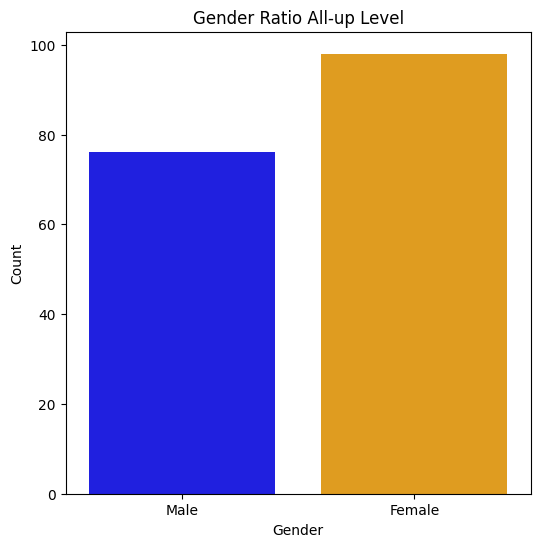

In [137]:
plt.figure(figsize=(6,6))
plt.title('Gender Ratio All-up Level')
sns.countplot(data=data, x='Gender', palette=['blue', 'orange'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

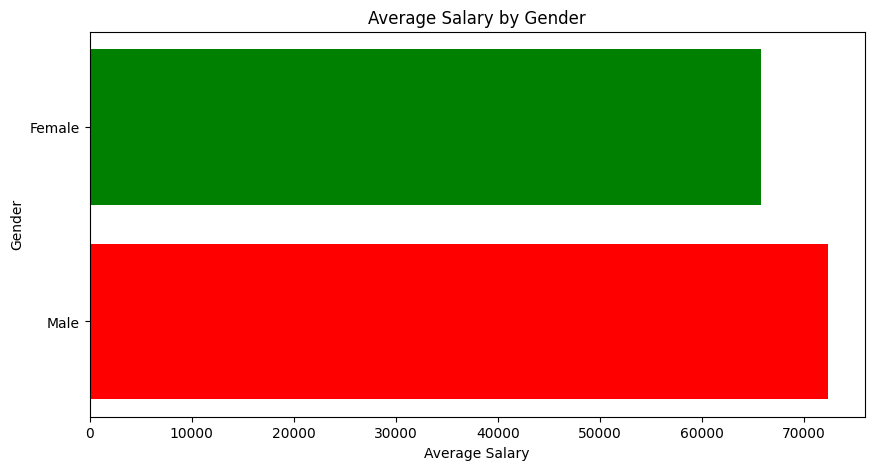

In [147]:
male_avg_salary = data[data['Gender'] == 'Male']['Salary'].mean()
female_avg_salary = data[data['Gender'] == 'Female']['Salary'].mean()
plt.figure(figsize=(10, 5))
plt.barh(['Male', 'Female'], [male_avg_salary, female_avg_salary], color=['Red', 'Green'])
plt.title('Average Salary by Gender')
plt.xlabel('Average Salary')
plt.ylabel('Gender')
plt.show()

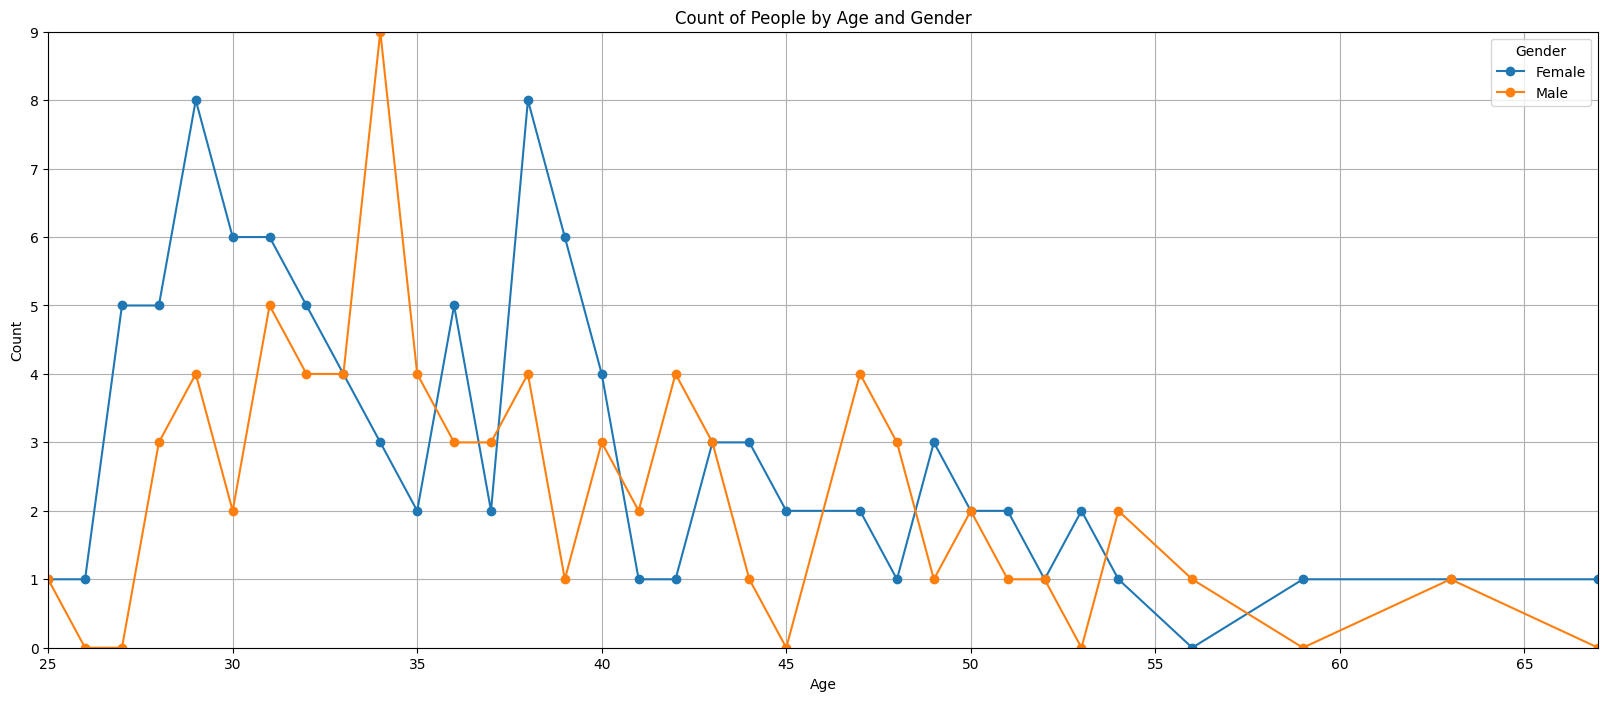

In [169]:
df = spark.sql(
    """
    SELECT Age, Gender, COUNT(*) AS Count 
    FROM PARQUET.`/Users/ronitguptaaa/Documents/Excel Analysis/Spark Fortress HR Data/HR-DATA-Final` 
    GROUP BY Age, Gender 
    ORDER BY Age ASC
    """
)
df_pandas = df.toPandas()

pivot_df = df_pandas.pivot(index='Age', columns='Gender', values='Count').fillna(0)

pivot_df.plot(kind='line', figsize=(20, 8), marker='o')

plt.title('Count of People by Age and Gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)
plt.legend(title='Gender')
plt.xlim(pivot_df.index.min(), pivot_df.index.max())
plt.ylim(0, pivot_df.values.max())
plt.show()


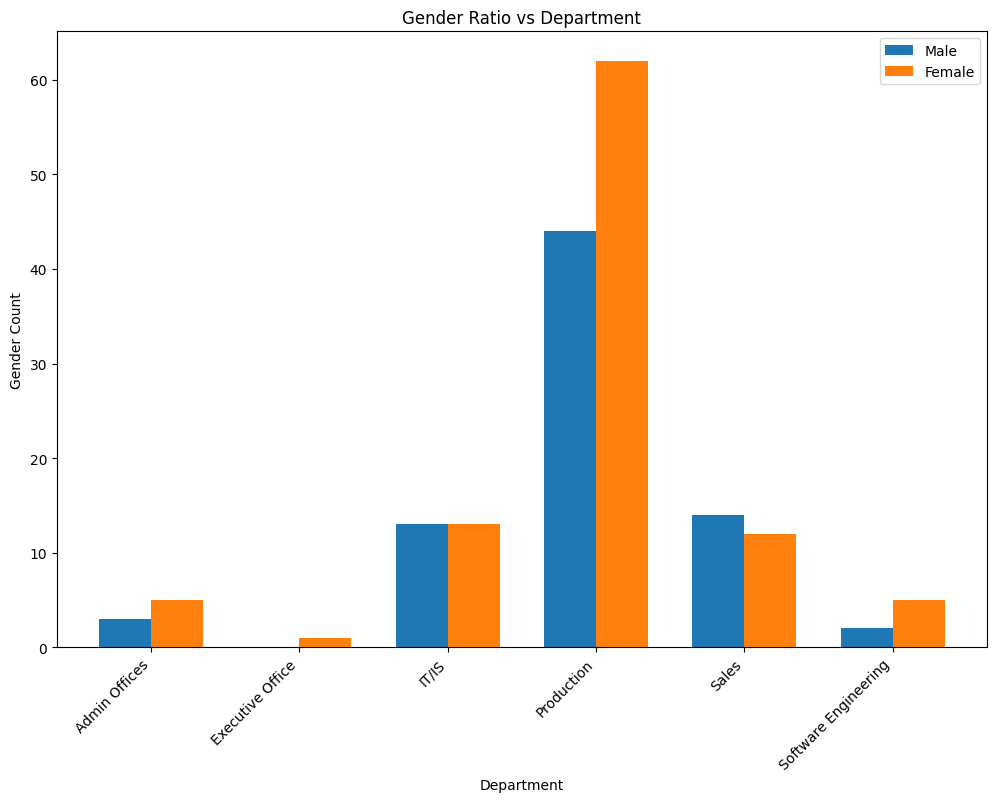

In [189]:
grouped_data = data.groupby(['Department', 'Gender']).sum().unstack()

departments = grouped_data.index
male_counts = grouped_data['count(Gender)']['Male']
female_counts = grouped_data['count(Gender)']['Female']
bar_width = 0.35

index = np.arange(len(departments))

plt.figure(figsize=(12, 8))
plt.bar(index, male_counts, bar_width, label='Male')
plt.bar(index + bar_width, female_counts, bar_width, label='Female')

plt.title('Gender Ratio vs Department')
plt.xlabel('Department')
plt.ylabel('Gender Count')
plt.xticks(index + bar_width / 2, departments, rotation=45, ha='right')
plt.legend()
plt.show()


/var/folders/ys/dxxwlhx16v3dl402b1gm7hrh0000gn/T/ipykernel_69206/3899173933.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='Department', y='AvgSalary', palette='viridis')


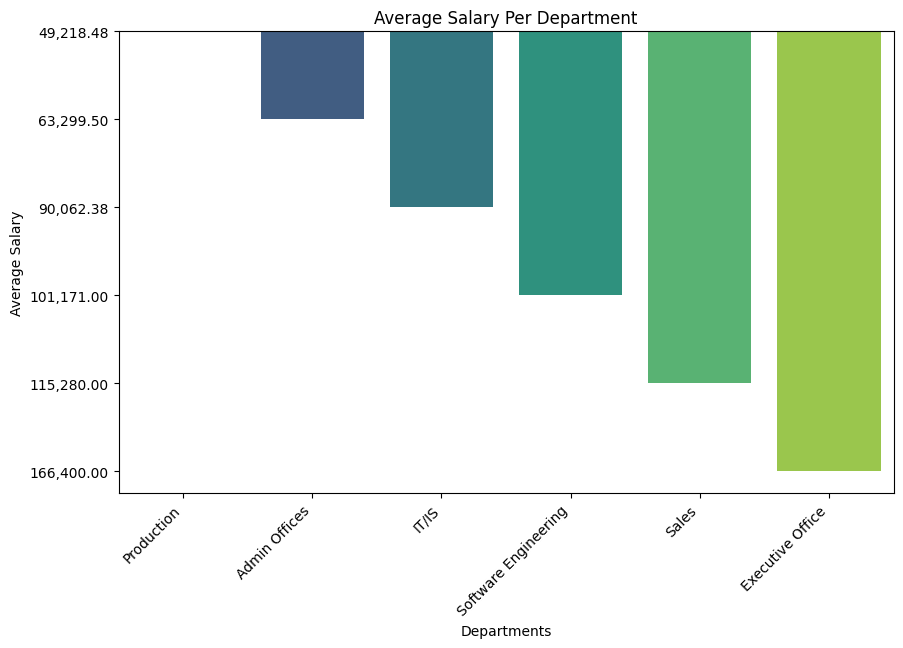

In [203]:
df = spark.sql(
    """SELECT Department, ROUND(AVG(Salary),2) AS AvgSalary FROM PARQUET.`/Users/ronitguptaaa/Documents/Excel Analysis/Spark Fortress HR Data/HR-DATA-Final`
        GROUP BY Department ORDER BY AvgSalary
    """
)
df = df.withColumn("AvgSalary", format_string('%,.2f', col('AvgSalary')))
data = df.toPandas()

plt.figure(figsize=(10, 6))
plt.title('Average Salary Per Department')
sns.barplot(data=data, x='Department', y='AvgSalary', palette='viridis')
plt.xlabel('Departments')
plt.ylabel('Average Salary')
plt.xticks(rotation=45, ha='right')
plt.show()

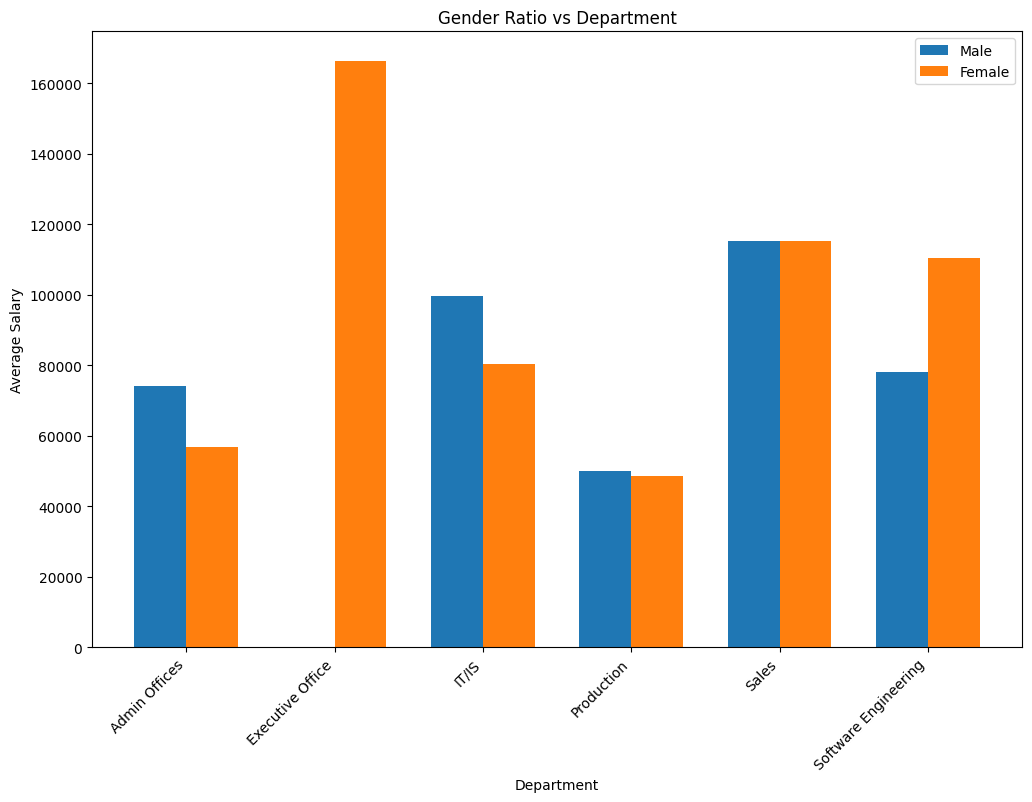

In [234]:
df = spark.sql(
    """
    SELECT format_number(CAST(ROUND(AVG(Salary)) AS INT), 0) AS AvgSalary, Department, Gender 
    FROM PARQUET.`/Users/ronitguptaaa/Documents/Excel Analysis/Spark Fortress HR Data/HR-DATA-Final` 
    GROUP BY Department, Gender 
    ORDER BY AvgSalary ASC
    """
)
data = df.toPandas()

grouped_data = data.groupby(['Department', 'Gender']).sum().unstack()

departments = grouped_data.index
male_avg_salary = grouped_data['AvgSalary']['Male'].str.replace(',', '').astype(float).fillna(0).astype(int)
female_avg_salary = grouped_data['AvgSalary']['Female'].str.replace(',', '').astype(float).fillna(0).astype(int)

bar_width = 0.35

index = np.arange(len(departments))

plt.figure(figsize=(12, 8))
plt.bar(index, male_avg_salary, bar_width, label='Male')
plt.bar(index + bar_width, female_avg_salary, bar_width, label='Female')

plt.title('Gender Ratio vs Department')
plt.xlabel('Department')
plt.ylabel('Average Salary')
plt.xticks(index + bar_width / 2, departments, rotation=45, ha='right')
plt.legend()
plt.show()
